In [7]:
%% file example_CMTL.m
% this file shows the usage of Least_CMTL.m function
% and study how to capture tasks clusters.
%
%% OBJECTIVE
% argmin_W { sum_i^t (0.5 * norm (Y{i} - X{i}' * W(:, i))^2) 
%            + rho1 * eta (1+eta) trace(W (eta I + M)^-1 W')
%     subject to: trace (M) = k, M \preceq I, M \in S_+^t, eta= rho2/rho1
%
%% LICENSE
%   This program is free software: you can redistribute it and/or modify
%   it under the terms of the GNU General Public License as published by
%   the Free Software Foundation, either version 3 of the License, or
%   (at your option) any later version.
%
%   This program is distributed in the hope that it will be useful,
%   but WITHOUT ANY WARRANTY; without even the implied warranty of
%   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
%   GNU General Public License for more details.
%
%   You should have received a copy of the GNU General Public License
%   along with this program.  If not, see <http://www.gnu.org/licenses/>.
%
%   Copyright (C) 2011 - 2012 Jiayu Zhou and Jieping Ye 
%
%   You are suggested to first read the Manual.
%   For any problem, please contact with Jiayu Zhou via jiayu.zhou@asu.edu
%
%   Last modified on June 3, 2012.
%
%% Related papers
%
% [1] J. Zhou, J. Chen and J. Ye, Clustered Multi-Task Learning via
% Alternating Structure Optimization, NIPS 2011.
%


clc;
clear;
close all;

addpath('../MALSAR/functions/CMTL/'); % load function
addpath('../MALSAR/utils/'); % load utilities



In [35]:
%rng('default'); % Available from Matlab 2011.

clus_var = 900;  % cluster variance
task_var = 16;   % inter task variance
nois_var = 150;  % variance of noise

clus_num = 2;                        % clusters
clus_task_num = 10;                  % task number of each cluster
task_num = clus_num * clus_task_num % total task number.
sample_size = 100;
dimension   = 20;        % total dimension
comm_dim    = 2;         % independent dimension for all tasks.
clus_dim    = floor((dimension - comm_dim)/2) % dimension of cluster

task_num =  20
clus_dim =  9


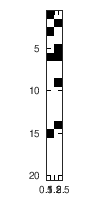

In [65]:
% generate cluster model
cluster_weight = randn(dimension, clus_num) * clus_var;
for i = 1: clus_num
    cluster_weight (randperm(dimension-clus_num)<=clus_dim, i) = 0;
end
cluster_weight (end-comm_dim:end, :) = 0;

figure(1, 'position',[0,0,100,200]);
imshow(1-cluster_weight)
axis ("on")

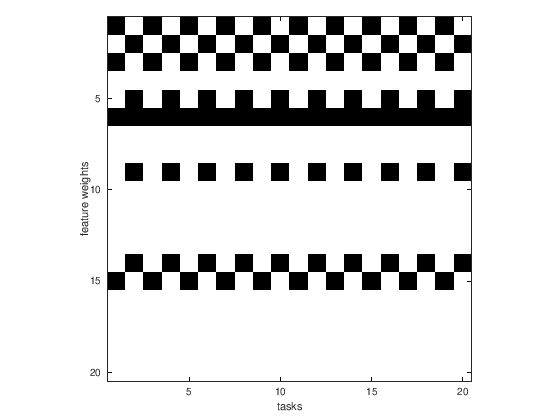

In [72]:
W = repmat (cluster_weight, 1, clus_task_num);
cluster_index = repmat (1:clus_num, 1, clus_task_num)';

imshow(1-W);

xlabel ("tasks");
ylabel ("feature weights");
axis ("on")

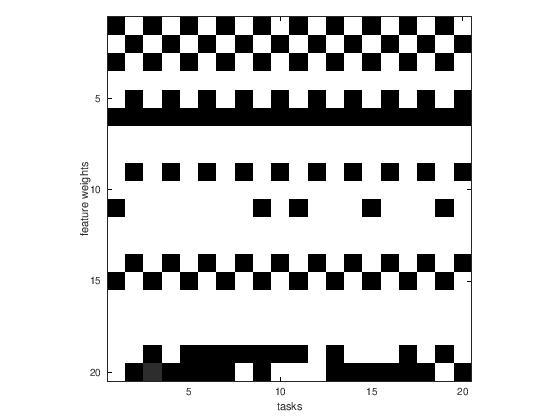

In [73]:
% generate task and intra-cluster variance
W_it = randn(dimension, task_num) * task_var;

for i = 1: task_num
    W_it(cat(1, W(1:end-comm_dim, i)==0, zeros(comm_dim, 1))==1, i) = 0;
end

W = W + W_it;

imshow(1-W)
xlabel ("tasks");
ylabel ("feature weights");
axis ("on")

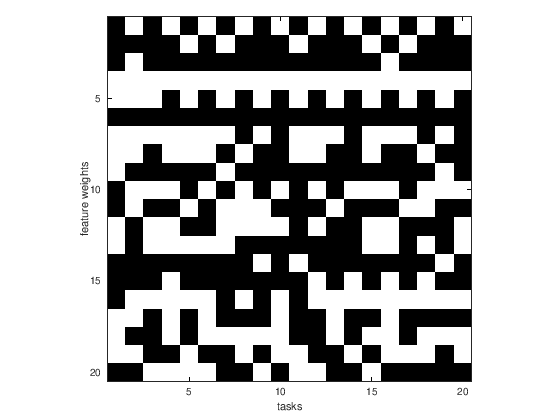

In [74]:
% apply noise;
W = W + randn(dimension, task_num) * nois_var;

imshow(1-W)
xlabel ("tasks");
ylabel ("feature weights");
axis ("on")

In [75]:

X = cell(task_num, 1);
Y = cell(task_num, 1);

for i = 1: task_num
    X{i} = randn(sample_size, dimension);
    xw   = X{i} * W(:, i);
    xw   = xw + randn(size(xw)) * nois_var;
    Y{i} = sign(xw);

    
end


In [91]:
xy = []

for i = 1: task_num
    xyc = corrcoef([X{i}, Y{i}]);
    txyc = xyc(1:end-1,end);
    xy = [xy, txyc];
    disp(size(xy))
end

disp(size(xy))

xy = [](0x0)
   20    1
   20    2
   20    3
   20    4
   20    5
   20    6
   20    7
   20    8
   20    9
   20   10
   20   11
   20   12
   20   13
   20   14
   20   15
   20   16
   20   17
   20   18
   20   19
   20   20
   20   20


    1    3    5    7    9   11   13   15   17   19
    1    2    3    4    5    6    7    8    9   10
    2    4    6    8   10   12   14   16   18   20
   11   12   13   14   15   16   17   18   19   20


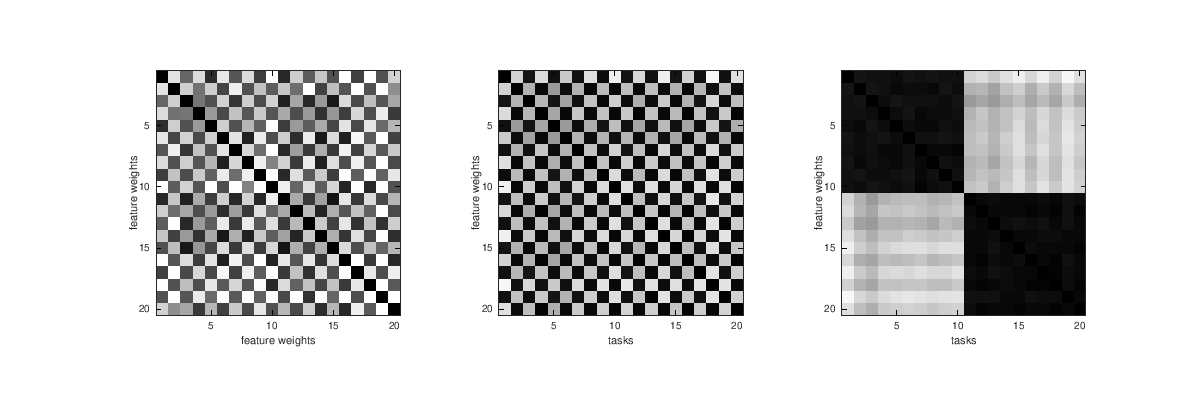

In [96]:



for i = 1: clus_num    
    ix_cluster_task = i:clus_num:task_num;
    ix_ordered_cluter = (i-1)* clus_task_num + 1: i* clus_task_num;
    
    disp(ix_cluster_task)
    disp(ix_ordered_cluter)
    
    clusModel = W(:, ix_cluster_task );
    OrderedTrueModel(:, ix_ordered_cluter ) = clusModel;
    xycm(:, ix_ordered_cluter ) = xy(:, ix_cluster_task );
end

figure(1, 'position',[0,0,1200,400]);

subplot (1, 3, 1)
imshow(1-corrcoef(xy))
xlabel ("feature weights");
ylabel ("feature weights");
axis ("on")

subplot (1, 3, 2)
imshow(1-corrcoef(W))
xlabel ("tasks");
ylabel ("feature weights");
axis ("on")

subplot (1, 3, 3)
imshow(1-corrcoef(OrderedTrueModel))
xlabel ("tasks");
ylabel ("feature weights");
axis ("on")

    imshow at line 144 column 11
    imshow at line 144 column 11


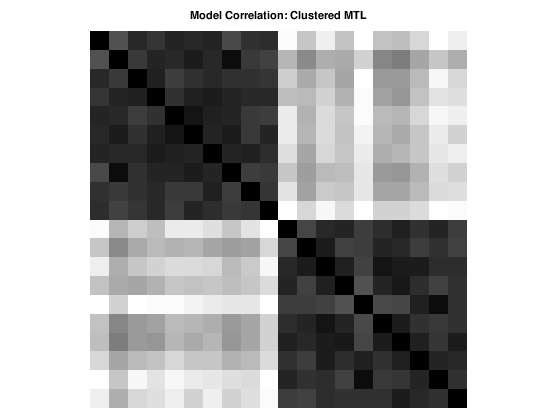

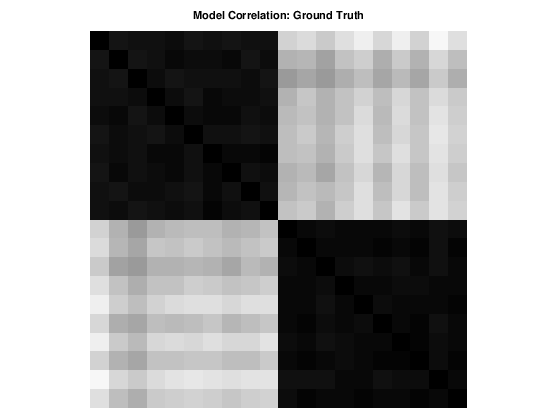

In [97]:




opts.init = 0;      % guess start point from data.
opts.tFlag = 1;     % terminate after relative objective value does not changes much.
opts.tol = 10^-6;   % tolerance.
opts.maxIter = 1500; % maximum iteration number of optimization.

rho_1 = 10;
rho_2 = 10^-1;

W_learn = Least_CMTL(X, Y, rho_1, rho_2, clus_num, opts);

kmCMTL_OrderedModel = zeros(size(W));
OrderedTrueModel = zeros(size(W));


for i = 1: clus_num
    clusModel = W_learn        (:, i:clus_num:task_num );
    kmCMTL_OrderedModel        (:, (i-1)* clus_task_num + 1: i* clus_task_num ) = clusModel;
    
    clusModel = W              (:, i:clus_num:task_num );
    OrderedTrueModel           (:, (i-1)* clus_task_num + 1: i* clus_task_num ) = clusModel;
end

figure;
imshow(1-corrcoef(OrderedTrueModel), 'InitialMagnification', 'fit')
%print -painters -dpdf -r1000 Figure/correlation_groundTruth.pdf
title('Model Correlation: Ground Truth')

figure;
imshow(1-corrcoef(kmCMTL_OrderedModel), 'InitialMagnification', 'fit')
%print -painters -dpdf -r1000 Figure/correlation_kmCMTL.pdf
title('Model Correlation: Clustered MTL');

